<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
!pip install ydata_profiling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ydata_profiling import ProfileReport
import re
import phik
from phik.report import plot_correlation_matrix
import statsmodels.api as sm

random.seed(42)
np.random.seed(42)


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


/Users/sergejpolunin/PycharmProjects/StreamlitMLApp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Сид позволяет проверяющему воспроизвести результаты полученные во время решения задач

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [3]:
for i in range(0, len(df_train)):
  try:
    ffil_value = float(df_train.loc[i, 'max_power'][:-4])
    df_train.loc[i, 'max_power'] = ffil_value

  except:
    if df_train.loc[i, 'max_power'] in [np.nan, 'nan']:
      continue
    elif df_train.loc[i, 'max_power'] == '0':
      ffil_value = float(df_train.loc[i, 'max_power'])
      df_train.loc[i, 'max_power'] = ffil_value
    else:
      df_train.loc[i, 'max_power'] = 0
print(df_train.isna().sum())
print("Колонки с пропусками в трейне:", df_train.columns[df_train.isna().any()].tolist())

print(df_test.isna().sum())
print("Колонки с пропусками в тесте:", df_test.columns[df_test.isna().any()].tolist())

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64
Колонки с пропусками в трейне: ['mileage', 'engine', 'max_power', 'torque', 'seats']
name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage          19
engine           19
max_power        19
torque           19
seats            19
dtype: int64
Колонки с пропусками в тесте: ['mileage', 'engine', 'max_power', 'torque', 'seats']


In [4]:
print("Дубликаты в трейне:", df_train.duplicated().sum())
print("Дубликаты в тесте:", df_test.duplicated().sum())


profile = ProfileReport(
    df_train,
    title="Cars Train Dataset Profile",
    explorative=True
)

profile.to_file("train_profile.html")

Дубликаты в трейне: 985
Дубликаты в тесте: 62


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 233.91it/s]


	Судя по ядате нужно
	    - Удалить дубликаты.
	    - Придумать что сделать с торком
	    - Обучить модель чтобы определить тип селлера скорее всего не выйдет, сильный дисбаланс (хотя мож у селлера будет какая то однородная картина)
	    - у mileage придется поприводить значения, километры на литры/километры на кг еще и в текстовом виде
        - По выбросам тяжело сказать, вроде на основании экстримальных значений в подробностях графиков прям нереальных выбросов не должно быть, я бы отдельно вывел гисты без нормализации значений

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [5]:
# your code here
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

print("Трейн")
display(df_train[num_cols].describe())

print("Тест")
display(df_test[num_cols].describe())

cat_cols = df_train.select_dtypes(include=['object']).columns

print("Трейн")
display(df_train[cat_cols].describe())

print("Тест")
display(df_test[cat_cols].describe())

print("Трейн")
train_mm = pd.DataFrame({
    'mean': df_train[num_cols].mean(),
    'median': df_train[num_cols].median()
})
display(train_mm)

print("Тест")
test_mm = pd.DataFrame({
    'mean': df_test[num_cols].mean(),
    'median': df_test[num_cols].median()
})
display(test_mm)

train_mean = df_train[num_cols].mean()
test_mean = df_test[num_cols].mean()

print("Разница среднее:")
print(train_mean - test_mean)

train_median = df_train[num_cols].median()
test_median = df_test[num_cols].median()

print("Разница медиана:")
print(train_median - test_median)

Трейн


,year,selling_price,km_driven,seats
count,6999.000000,6.999000e+03,6.999000e+03,6797.000000
mean,2013.818403,6.395152e+05,6.958462e+04,5.419008
std,4.053095,8.089419e+05,5.772400e+04,0.965767
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.700000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


Тест


,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


Трейн


,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803.0,6796
unique,1924,4,3,2,5,386,120,313.0,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74.0,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330.0,468


Тест


,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


Трейн


,mean,median
year,2013.818403,2015.0
selling_price,639515.197171,450000.0
km_driven,69584.615517,60000.0
seats,5.419008,5.0


Тест


,mean,median
year,2013.681000,2014.0
selling_price,617901.042000,434999.0
km_driven,71393.341000,61500.0
seats,5.410805,5.0


Разница среднее:
year                 0.137403
selling_price    21614.155171
km_driven        -1808.725483
seats                0.008203
dtype: float64
Разница медиана:
year                 1.0
selling_price    15001.0
km_driven        -1500.0
seats                0.0
dtype: float64


Ну судя и по предыдущему анализу, разница между сетами не очень большая. Чего то явно выделяющегося не видно. (Разве что года у теста с 95 а у трейна с 83, не дуааю что это приведет к проблеме). У цены отклонение от стд большое, но для цен на машины наверное это ожидаемое поведение.

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [6]:
# your code here
feature_cols = df_train.columns.drop('selling_price')
duplicates_mask = df_train.duplicated(subset=feature_cols, keep=False)

num_duplicates = duplicates_mask.sum()
print("Дубликаты в трейне:", num_duplicates)
df_train[duplicates_mask].sort_values(feature_cols.tolist()).head(20)

df_train = df_train.drop_duplicates(subset=feature_cols, keep='first')
df_train = df_train.reset_index(drop=True)


Дубликаты в трейне: 1799


Ну понятно где могут быть скрытые дубли - в значениях с разными единицами измерения (писал про них выше). В текстовых значениях с разным порядком, может модели машин с опечатками, может в торке порядок разный.
Следующий шаг должен помочь, после него можно будет опять пройтись по дублям. Для строк типа марки авто можно ввести фаззи сравнение (чтоб опечатки не учитывать), но оно зависит от того на сколько обычно отличается значение

In [7]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [8]:
# your code here

#проверим какие единицы иземерения в столбцах и можно ли их просто отбросить
def unique_units(series, name):
    units = set()
    for x in series.dropna():
        u = ''.join(re.findall(r'[A-Za-z]+', str(x)))
        units.add(u)
    print(name, units)

print("Трейн:")
unique_units(df_train['mileage'], 'mileage')
unique_units(df_train['engine'], 'engine')
unique_units(df_train['max_power'], 'max_power')

print("\nТест:")
unique_units(df_test['mileage'], 'mileage')
unique_units(df_test['engine'], 'engine')
unique_units(df_test['max_power'], 'max_power')
#ну вот kmpl и kmkg надо привести к 1
def convert_mileage(series):
    numeric = (
        series.astype(str)
              .str.extract(r'([\d.]+)')
              .astype(float)
    )
    units = series.astype(str).str.extract(r'([A-Za-z]+)', expand=False)

    result = numeric.copy()
    mask_kmkg = units == 'kmkg'
    result[mask_kmkg] = numeric[mask_kmkg] / 1.2 #спросил у гпт как проще перевести
    return result

def drop_units(series):
    return (
        series.astype(str)
              .str.extract(r'([\d.]+)', expand=False)
              .astype(float)
    )

for df in (df_train, df_test):
    df["engine"] = drop_units(df["engine"])
    df["max_power"] = drop_units(df["max_power"])
    df["mileage"] = convert_mileage(df["mileage"])




Трейн:
mileage {'kmpl', 'kmkg'}
engine {'CC'}
max_power {''}

Тест:
mileage {'kmpl', 'kmkg'}
engine {'CC'}
max_power {'bhp'}


In [9]:
#посмотрим сначала что там вобще в торке
def inspect_torque(series, name):
    units = set()
    for x in series.dropna():
        tokens = re.findall(r'[A-Za-z]+', str(x))
        units.update(tokens)
    print(f"Уникальные буквенные токены в {name}:")
    print(units)
    print()

    patterns = set()
    for x in series.dropna():
        s = str(x)
        patt = re.sub(r'[\d.\s]', '', s)
        patterns.add(patt)
    print(f"Примеры разных форматов строки в {name}:")
    for p in list(patterns)[:20]:
        print("  ", p)


print("Трейн")
inspect_torque(df_train["torque"], "train.torque")

print("\nТест")
inspect_torque(df_test["torque"], "test.torque")

Трейн
Уникальные буквенные токены в train.torque:
{'Nm', 'kgm', 'rpm', 'KGM', 'NM', 'nm', 'at', 'RPM'}

Примеры разных форматов строки в train.torque:
   Nm
   /
   kgmat,rpm
   @-(kgm@rpm)
   @,+/-(NM@rpm)
   Nmat,-,rpm
   Nm@~rpm
   Nm@+/-rpm
   @-rpm
   Nm@
   Nm@-
   Nm(kgm)@rpm
   nm@-rpm
   NM@rpm
   NM@-rpm
   kgm@rpm
   Nm/rpm
   @,-,(kgm@rpm)
   Nmatrpm
   nm@rpm

Тест
Уникальные буквенные токены в test.torque:
{'Nm', 'kgm', 'rpm', 'KGM', 'NM', 'nm', 'at', 'RPM'}

Примеры разных форматов строки в test.torque:
   Nm
   kgmat,rpm
   @-(kgm@rpm)
   @,+/-(NM@rpm)
   ()@
   Nm@+/-rpm
   Nm@-
   nm@-rpm
   NM@rpm
   NM@-rpm
   kgm@rpm
   @,-,(kgm@rpm)
   Nmatrpm
   nm@rpm
   KGMat-RPM
   @,(kgm@rpm)
   @(kgm@rpm)
   Nm@,rpm
   kgmat-rpm
   Nm@-rpm


In [10]:
#ну хотя бы порядок стабильный и то хорошо
def parse_torque_value(x):
    if pd.isna(x):
        return np.nan, np.nan

    s = str(x).strip()
    if not s or s == '/':
        return np.nan, np.nan

    s_low = s.lower()
    nums = re.findall(r'(\d+(?:\.\d+)?)', s_low)
    if not nums:
        return np.nan, np.nan

    torque_val = float(nums[0])

    if 'kgm' in s_low:
        torque_val = torque_val * 9.8  # спросил у гпт формулу


    rpm_val = np.nan
    if len(nums) >= 2:
        rpm_candidates = [float(n) for n in nums[1:]]
        rpm_val = max(rpm_candidates)

    return torque_val, rpm_val


def split_torque(series):
    torques = []
    rpms = []
    for x in series:
        t, r = parse_torque_value(x)
        torques.append(t)
        rpms.append(r)
    return pd.Series(torques, index=series.index), pd.Series(rpms, index=series.index)


for df in (df_train, df_test):
    torque_nm, torque_rpm = split_torque(df["torque"])
    df["torque"] = torque_nm
    df["max_torque_rpm"] = torque_rpm

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [11]:
cols_with_na = df_train.columns[df_train.isna().any()].tolist()
print("Пропуски", cols_with_na)

median_values = df_train[cols_with_na].median()

df_train[cols_with_na] = df_train[cols_with_na].fillna(median_values)
df_test[cols_with_na]  = df_test[cols_with_na].fillna(median_values)


Пропуски ['mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


Использование медианы оправдано тем что среднего значения может просто не быть в датасете - в итоге мы просто создадим новый синт класс
Еще среднее не обязательно показывает самые обычные значения в датасете
Могли бы среднее применить если бы у нас не было такого разброса стд
я бы конечно еще заполнял медиану по моделям хотя бы, но датасет маленький, так что не буду
ну и заполнять будем все трейном, чтобы не использовать данные теста для помощи модели

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [12]:
# your code here
df_train["engine"] = df_train["engine"].astype(int)
df_test["engine"]  = df_test["engine"].astype(int)

df_train["seats"] = df_train["seats"].astype(int)
df_test["seats"]  = df_test["seats"].astype(int)

Потому что сиденья это дискретное значение, к тому же ограниченное снизу 1 (или 0 для особых экстремалов) да еще и чсило значений мало
к тому же разница между сиденьями не обязательно одинакова для случаев с 1 2 3 4 и 5 сиденьями

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [13]:
# your code here
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

print("Трейн")
display(df_train[num_cols].describe())

print("Тест")
display(df_test[num_cols].describe())

cat_cols = df_train.select_dtypes(include=['object']).columns

print("Трейн")
display(df_train[cat_cols].describe())

print("Тест")
display(df_test[cat_cols].describe())

print("Трейн")
train_mm = pd.DataFrame({
    'mean': df_train[num_cols].mean(),
    'median': df_train[num_cols].median()
})
display(train_mm)

print("Тест")
test_mm = pd.DataFrame({
    'mean': df_test[num_cols].mean(),
    'median': df_test[num_cols].median()
})
display(test_mm)


Трейн


,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.430841,1429.448973,87.892354,175.919680,5.426712,2911.513185
std,4.095622,5.354320e+05,6.007114e+04,3.985973,485.662834,31.661223,116.714313,0.982344,1028.895042
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,47.040000,2.000000,2.000000
25%,2011.000000,2.500000e+05,3.900000e+04,16.950000,1197.000000,68.000000,111.800000,5.000000,2000.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.370000,1248.000000,81.860000,160.000000,5.000000,2800.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.300000,1498.000000,99.000000,200.000000,5.000000,3800.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,3724.000000,14.000000,5300.000000


Тест


,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,1000.000000,1.000000e+03,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2013.681000,6.179010e+05,71393.341000,19.33881,1454.87600,90.841670,177.608530,5.403000,2986.158000
std,4.012149,7.585539e+05,48486.218662,3.95175,521.99574,34.893389,103.711762,0.912921,999.516837
min,1995.000000,3.100000e+04,1303.000000,0.00000,624.00000,34.200000,48.000000,4.000000,2.000000
25%,2011.000000,2.500000e+05,37000.000000,16.55000,1197.00000,69.000000,111.700000,5.000000,2250.000000
50%,2014.000000,4.349990e+05,61500.000000,19.37000,1248.00000,82.425000,160.000000,5.000000,2800.000000
75%,2017.000000,6.700000e+05,100000.000000,22.30000,1582.00000,102.000000,205.000000,5.000000,4000.000000
max,2020.000000,6.000000e+06,375000.000000,32.26000,3604.00000,280.000000,1421.000000,9.000000,5200.000000


Трейн


,name,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840,5840
unique,1924,4,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,91,3177,5223,5336,3603


Тест


,name,fuel,seller_type,transmission,owner
count,1000,1000,1000,1000,1000
unique,621,4,3,2,5
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner
freq,15,534,837,877,623


Трейн


,mean,median
year,2013.428425,2014.00
selling_price,522960.091096,405000.00
km_driven,73952.242466,70000.00
mileage,19.430841,19.37
engine,1429.448973,1248.00
max_power,87.892354,81.86
torque,175.919680,160.00
seats,5.426712,5.00
max_torque_rpm,2911.513185,2800.00


Тест


,mean,median
year,2013.68100,2014.000
selling_price,617901.04200,434999.000
km_driven,71393.34100,61500.000
mileage,19.33881,19.370
engine,1454.87600,1248.000
max_power,90.84167,82.425
torque,177.60853,160.000
seats,5.40300,5.000
max_torque_rpm,2986.15800,2800.000


Ну так то там всего 200 пропусков +- было в трейне и 19 в тесте, нет оснований предполагать что медиана нам что-то испортит, есть основание полагать что сейчас будет разница в вызове из-за чистки дублей (ведь значения мы заполнили в колонках в которых не считали до этого статистики)

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

<Figure size 1400x1000 with 0 Axes>

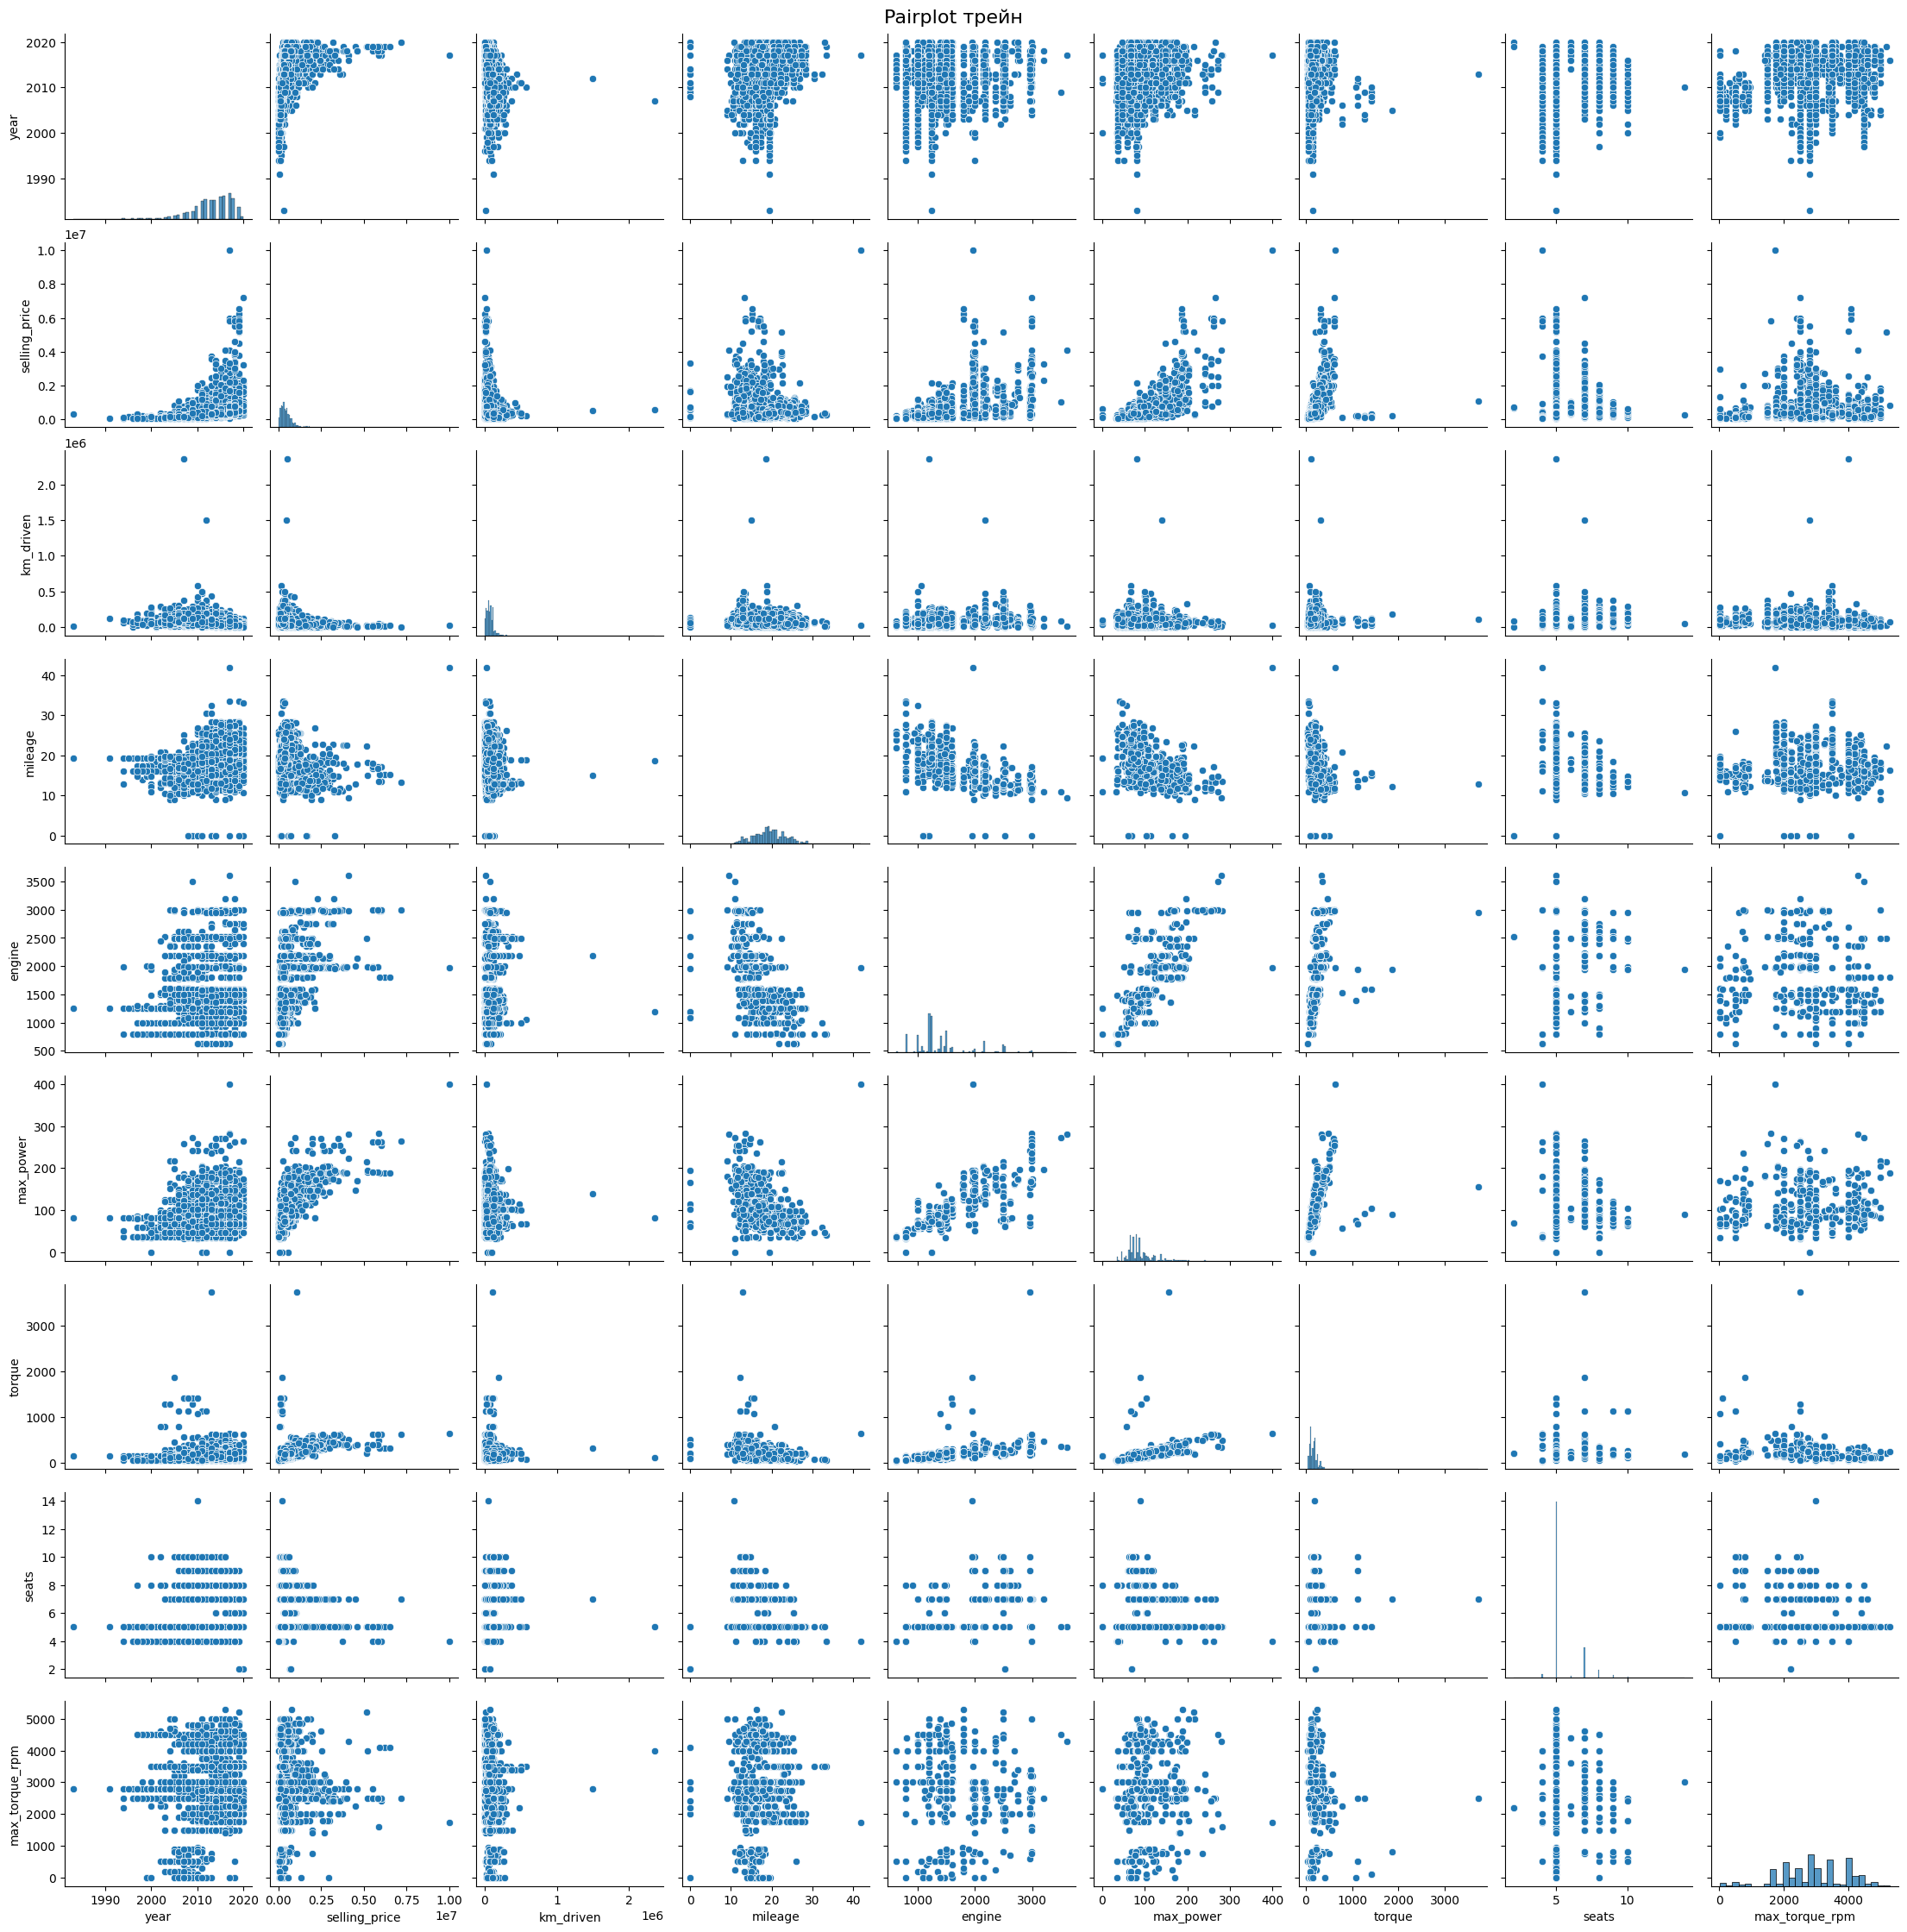

<Figure size 1400x1000 with 0 Axes>

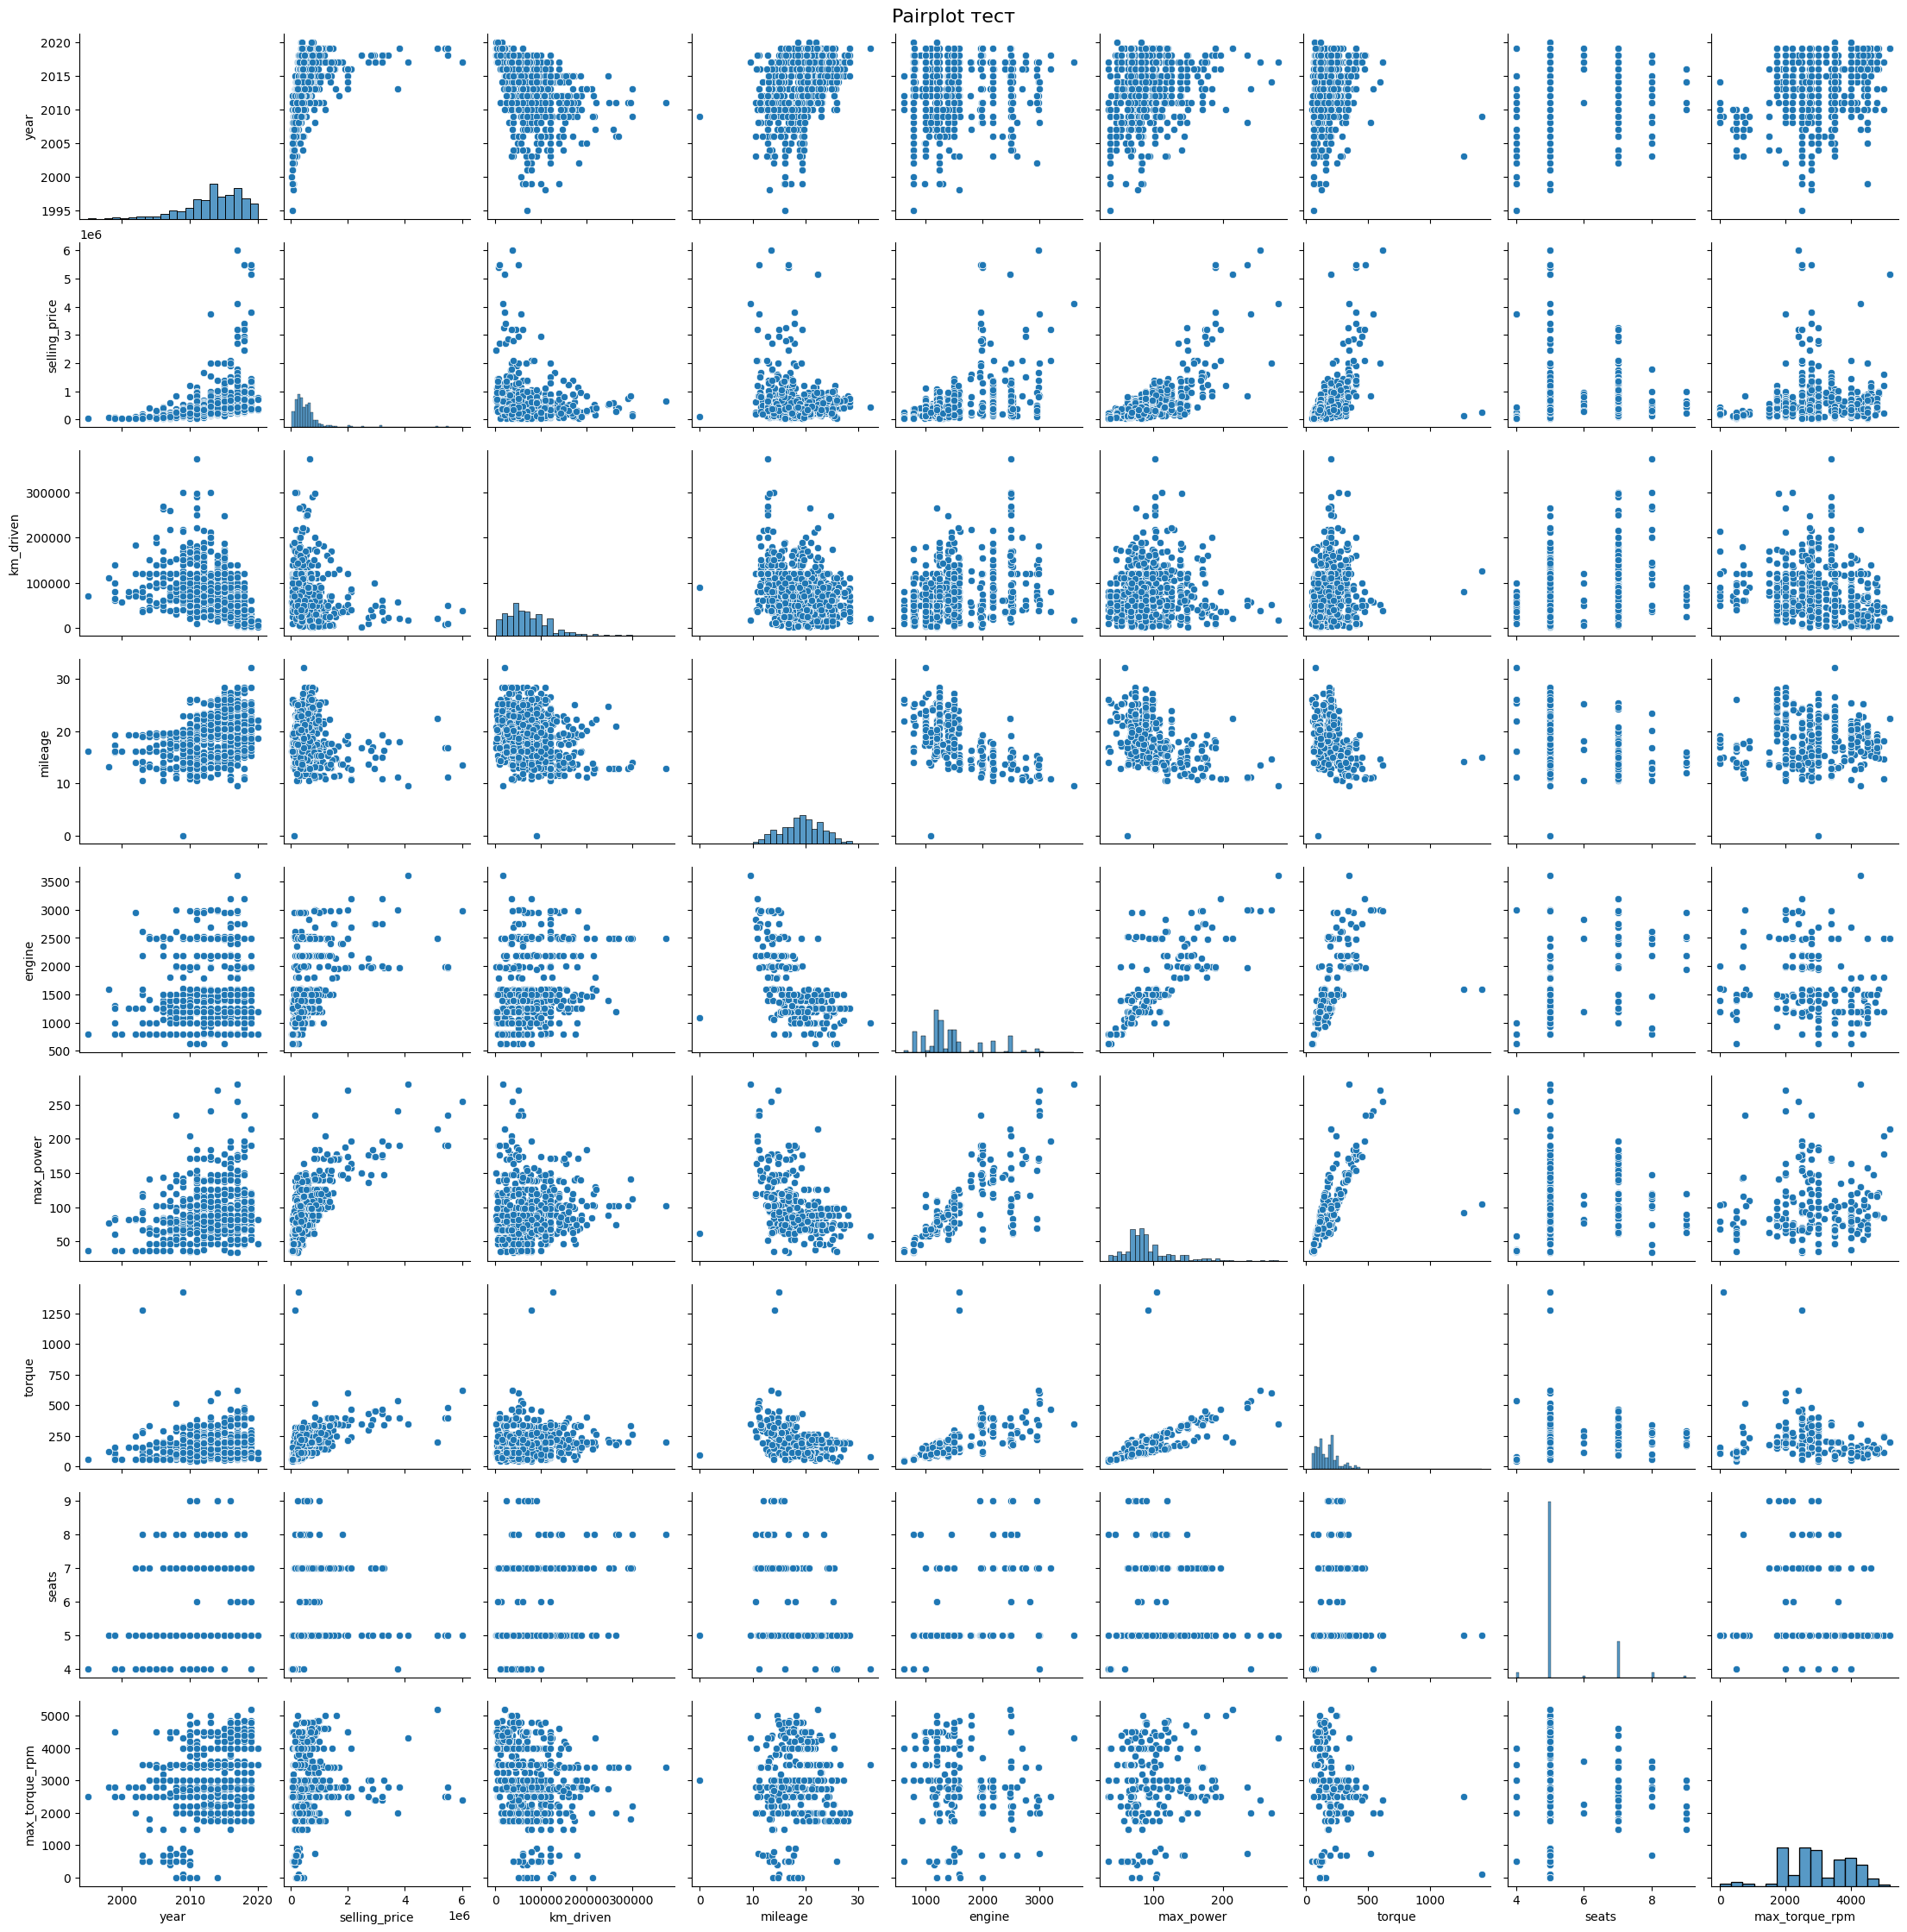

In [14]:
# your code here
%matplotlib inline

plt.figure(figsize=(14, 10))
sns.pairplot(df_train[num_cols])
plt.suptitle("Pairplot трейн", y=1, fontsize=16)
plt.show()
plt.figure(figsize=(14, 10))
sns.pairplot(df_test[num_cols])
plt.suptitle("Pairplot тест", y=1, fontsize=16)
plt.show()

Связь с целевой:
*     max_power
*     engine
*     year
Обратная
*     km_driven

у seats странного вида распределение
Корреляции с другими признаками
* engine и max_power
* engine и torque
* max_power и torque
* year и km_driven

В тесте видно примерно такие же взаимосвязи, заметное большее разрежение данных (собственно значений меньше, логично) (хотя вот в таком виде сравнивать совсем неудобно, есть конечно заметные прямые линии тренда)

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

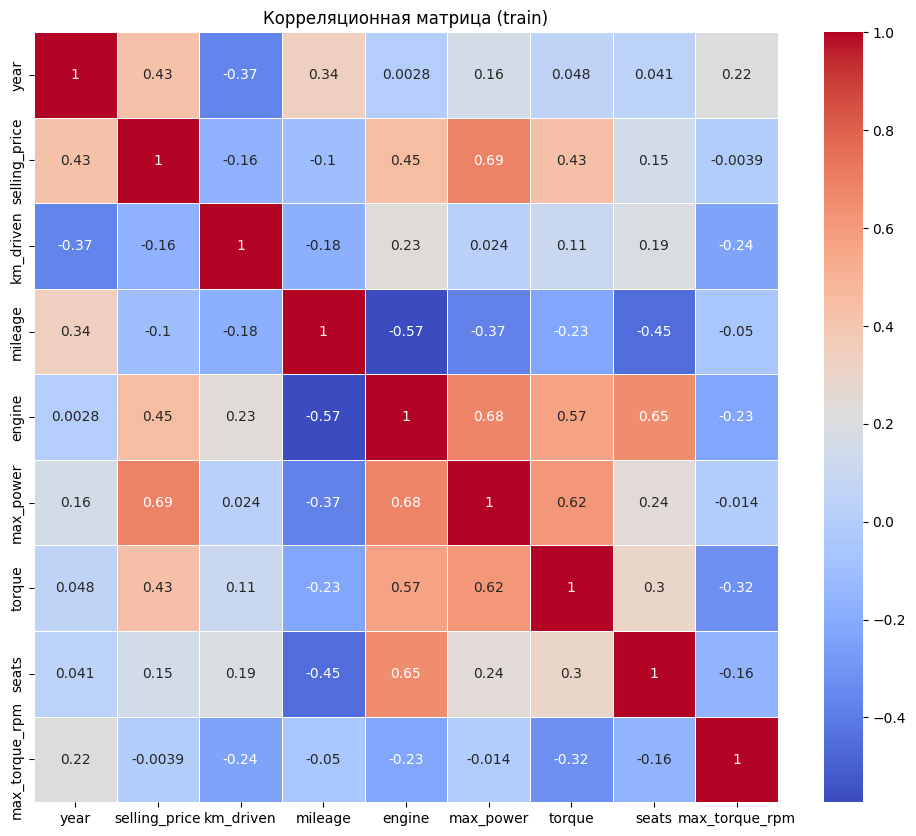

In [15]:
# your code here
corr_matrix = df_train[num_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Корреляционная матрица (train)")
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

Наименьшая корреляция у engine и year (ближайшая к 0)
Довольно сильная у:
* max_power и целевая - 0.69
* engine и max_power - 0.68
* engine и seats - 0.65
* max_power и torque - 0.62
* torque и engine - 0.57
Да, обратная корреляция между годом и км есть, значит чем меньше год, тем, скорее всего, больше километров проехала машина.
По умолчанию стоит pearson (собственно его и нужно было сделать по заданию), ну а другие описаны прямо в следующем абзаце

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


свой Спирмен: 0.6127079012323355
pandas Спирмен: 0.6125998728357858


/Users/sergejpolunin/PycharmProjects/StreamlitMLApp/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(
/Users/sergejpolunin/PycharmProjects/StreamlitMLApp/.venv/lib/python3.12/site-packages/phik/bivariate.py:255: UserWarning: Many cells: 1591148. Are interval variables set correctly?
  warnings.warn(


<Figure size 1200x1000 with 0 Axes>

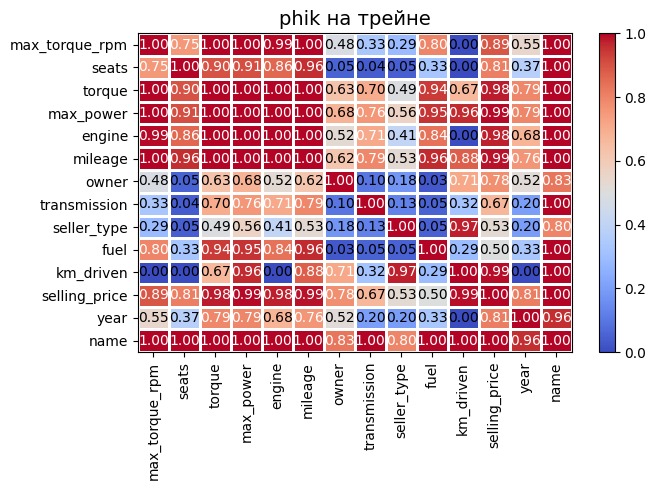

In [16]:
# your code here
# буду делать спирмена
# для него надо посчитать ранги, вычислить сумму их разностей квадратов и использовать формулу (взятую из интернета)
def rankdata(x):
    result = np.empty(len(x), float)
    x = np.asarray(x)

    sorted = np.argsort(x)
    x_sorted = x[sorted]
    # считаем ранги
    ranks = np.zeros(len(x), dtype=float)
    unique, first = np.unique(x_sorted, return_index=True)
    last = np.r_[first[1:], len(x_sorted)] #это для одинаковых по значению
    for f, l in zip(first, last):
        avg_rank = 0.5 * (f + l - 1) + 1
        ranks[f:l] = avg_rank

    result[sorted] = ranks
    return result


def spearman_corr(x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    n = len(x)

    rx = rankdata(x)
    ry = rankdata(y)

    d = rx - ry
    rs = 1 - (6 * np.sum(d ** 2)) / (n * (n**2 - 1)) #та самая формула
    return rs
    #return np.corrcoef(rx, ry)[0, 1]

col1 = "selling_price"
col2 = "max_power"

manual_corr = spearman_corr(df_train[col1], df_train[col2])
pandas_corr = df_train[[col1, col2]].corr(method="spearman").iloc[0, 1]

print("свой Спирмен:", manual_corr)
print("pandas Спирмен:", pandas_corr)


corr_phik = df_train.phik_matrix(interval_cols=[])

plt.figure(figsize=(12, 10))
plot_correlation_matrix(
    corr_phik.values,
    x_labels=corr_phik.columns,
    y_labels=corr_phik.index,
    vmin=0, vmax=1,
    color_map="coolwarm",
    title="phik на трейне"
)
plt.show()


Классическая формула почти совпадает с библиотечной, как оказалось моя реализация не совсем корректно использована (ллмка сказала что в моей формуле не оч хорошо учитываются повторяющиеся значения), я вот решил использовать встроенную в нумпай функцию расчета корреляции и получил идентичный библиотечной ответ

С нелинейной корреляцией совсем другой разговор - сразу видна куча зависимостей оправданных и нет. Например зависимость с name надо сразу убрать - это признак которого будет точно не достаточно в проде для предсказания, так мы просто испортим модельку дав ей прямо инфу для прохождения теста

Почти все переменные очень сильно коррелированы с целевой (на мой взгляд логично), надо будет их оптимально использовать. Очевидны корреляции с нашими разнесенными признаками из торка.

Забавно выглядит зависимость для числа мест, но на самом деле логично (меньше мест вероятнее спорткар - больше минибас)



### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

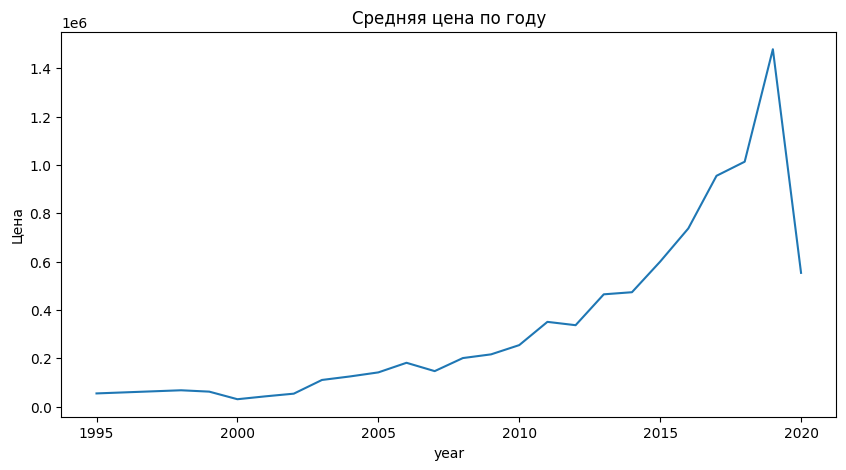

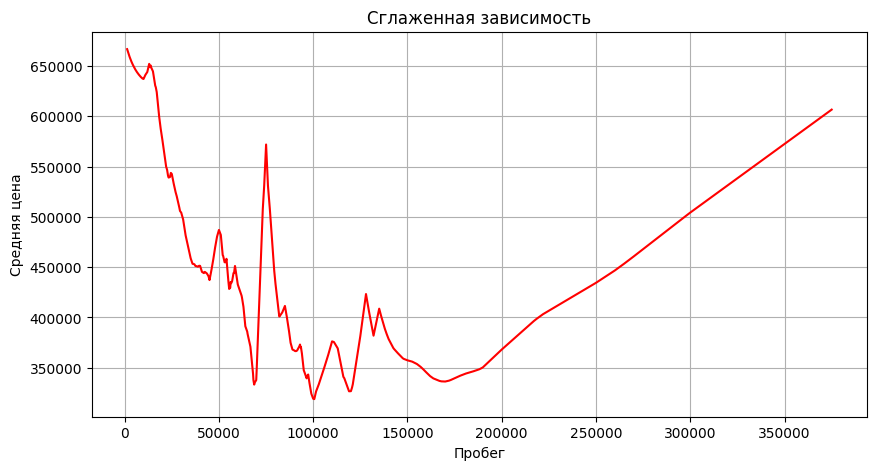

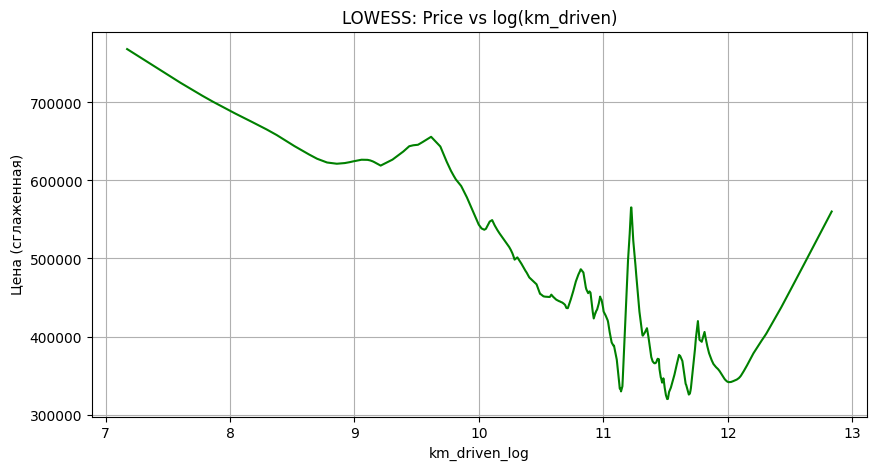

In [17]:
# your code here
# тип зависимости в обычных скаттерплотах плохо проглядывается, я остваил только подающие надежды графики
# сначала смотрим просто по году
plt.figure(figsize=(10, 5))
df.groupby("year")["selling_price"].mean().plot()
plt.title("Средняя цена по году")
plt.ylabel("Цена")
plt.show()
# график хорошо показывает тип зависимости - она не линейная, это будет важно потом
# еще видна резкая смена поведения после определенного года, можно капнуть поглубже
#display(df[df["year"] >= 2018].sort_values("year").tail(50))
#похоже на рынке остались только дешевые модели

#посмотрим на цену от пройденного расстояния
#сгладим ее через ловесс, так видно лучше
lowess = sm.nonparametric.lowess
z = lowess(df["selling_price"], df["km_driven"], frac=0.1)
plt.figure(figsize=(10, 5))
plt.plot(z[:, 0], z[:, 1], color="red")

plt.xlabel("Пробег")
plt.ylabel("Средняя цена")
plt.title("Сглаженная зависимость")

plt.grid(True)
plt.show()
#из-за вытянутой правой части кажется что у нас до нее не проглядывается зависимость, но там много машин, попробуем сгладить разброс расстояния
df["km_driven_log"] = np.log1p(df["km_driven"])

z = sm.nonparametric.lowess(df["selling_price"], df["km_driven_log"], frac=0.1)
plt.figure(figsize=(10, 5))
plt.plot(z[:,0], z[:,1], color="green")
plt.xlabel("km_driven_log")
plt.ylabel("Цена (сглаженная)")
plt.title("LOWESS: Price vs log(km_driven)")
plt.grid(True)
plt.show()
#теперь понятно что надо получше поработать с категориями для пробега



# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [18]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [19]:
print(df_train.columns.tolist())
numeric_cols = [
    "mileage",
    "engine",
    "max_power",
    "torque",
    "max_torque_rpm",
    "km_driven",
]

df_num_train = df_train[numeric_cols + ["selling_price"]].copy()
df_num_test = df_test[numeric_cols + ["selling_price"]].copy()

X_train = df_num_train.drop(columns=["selling_price"])
y_train = df_num_train["selling_price"]
X_train_for_bonus = df_num_train.drop(columns=["selling_price"])
y_train_for_bonus = df_num_train["selling_price"]

['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


In [20]:
assert X_train.shape == (5840, 6)

In [21]:
X_test = df_num_test.drop(columns=["selling_price"])
y_test = df_num_test["selling_price"]
X_test_for_bonus = df_num_test.drop(columns=["selling_price"])
y_test_for_bonus = df_num_test["selling_price"]

In [22]:
assert X_test.shape == (1000, 6)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [23]:
def calc_stats(y_train, y_pred_train, y_test, y_pred_test):
  r2_train = r2_score(y_train, y_pred_train)
  r2_test = r2_score(y_test, y_pred_test)

  mse_train = MSE(y_train, y_pred_train)
  mse_test = MSE(y_test, y_pred_test)

  print("R^2 трейн:", r2_train)
  print("R^2 тест :", r2_test)
  print("\nMSE трейн:", mse_train)
  print("MSE тест :", mse_test)

In [24]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test_first_linear = model.predict(X_test)

calc_stats(y_train, y_pred_train, y_test, y_pred_test_first_linear)

R^2 трейн: 0.5386311109904716
R^2 тест : 0.5690228966771467

MSE трейн: 132246011715.71541
MSE тест : 247737945816.31638


У регрессии среднее качество по R^2 равной  0.54 на тесте и 0.57 на трейне, можно предположить, что модель не переобучена
MSE на тесте выше, ожидаемый результат
На корреляциях уже было понятно, что чисто линейная модель покажет себя хуже чем нелинейная

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [25]:
#судя по моему ресерчу сцикит использует расчет через  1 - residual sum of square / total sum of squares, поэтому делаю по данной формуле
def r2_manual(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    ss_res = np.sum((y_true - y_pred)**2)
    ss_tos = np.sum((y_true - np.mean(y_true))**2)

    return 1 - ss_res / ss_tos

r2_manual_val = r2_manual(y_test, y_pred_test_first_linear)
print("ручная:", r2_manual_val)

ручная: 0.5690228966771467


ss_res - Сумма квадратов ошибок. По сути каждую ошибку возводим в квадрат и суммируем, соответственно ошибки усиливаются в идеале 0


ss_tos - Сумма квадратов отклонений. Вычитаем значение из среднего, возводим в квадрат

их частность - показатель того на сколько хуже модель чем просто выдача среднего

1 - нужна для того чтобы проще понять результат. Чтобы посмотреть как хорошо модель справляется, а не как плохо

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [26]:
# your code here
def adjusted_r2(y_true, y_pred, p):
    r2 = r2_manual(y_true, y_pred)
    n = len(y_true)

    return 1 - (1 - r2) * (n - 1) / (n - p - 1) # с вики

p = X_train.shape[1]

r2_train = r2_manual(y_train, y_pred_train)
r2_test  = r2_manual(y_test,  y_pred_test_first_linear)

adj_r2_train = adjusted_r2(y_train, y_pred_train, p)
adj_r2_test  = adjusted_r2(y_test,  y_pred_test_first_linear,  p)

print("Adj R^2 трейн:    ", adj_r2_train)
print("Adj R^2 тест:     ", adj_r2_test)

Adj R^2 трейн:     0.5381565330144631
Adj R^2 тест:      0.5664188054183983


Применяется когда нам нужно оценить кач-во модели убрав из рассмотрения подогнанные признаки. Нужно чтобы не было переобучения при докидывании в модель признаков со слабой корреляцией, еще может, чтобы сравнить модель с разным кол-вом признаков, чтобы оценить правда ли признак улучшил модель

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [27]:


scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_test_upd_linear = model.predict(X_test_scaled)

calc_stats(y_train, y_pred_train, y_test, y_pred_test_upd_linear)


R^2 трейн: 0.5386311109904716
R^2 тест : 0.5690228966771451

MSE трейн: 132246011715.71541
MSE тест : 247737945816.3173


Я не очень понимаю как стандартизация признаков поможет для регрессии учитывая что стандартизация признаков не влияет на R^2 и MSE

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [28]:
# your code here
features = X_train.columns

features_top = pd.DataFrame({
    "feature": features,
    "coef":  model.coef_,
    "abs_coef": np.abs( model.coef_)
}).sort_values("abs_coef", ascending=False)

features_top.head(1)

,feature,coef,abs_coef
2,max_power,358167.376075,358167.376075


Максимальная мощность оказалась важнее (ну у нее и корреляция максимальная)

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [29]:

display(X_train_scaled.mean(axis=0))
# your code here
lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

y_pred_train_lasso = lasso.predict(X_train_scaled)
y_pred_test_lasso = lasso.predict(X_test_scaled)

calc_stats(y_train, y_pred_train, y_test, y_pred_test_lasso)

coefs = lasso.coef_
display(coefs)
zero_mask = np.abs(coefs) < 1e-6

print("\nкоэффициентов занулено:", zero_mask.sum())
print("зануленное:")
for feat, coef in zip(X_train.columns, coefs):
    if np.isclose(coef, 0, atol=1e-6):
        print(feat, coef)

array([-9.28328951e-16, -1.30185056e-16, -6.14424797e-17,  1.24101642e-16,
        1.97102608e-16, -6.20508211e-17])

R^2 трейн: 0.5386311109904716
R^2 тест : 0.5690219578224822

MSE трейн: 132246011715.71541
MSE тест : 247738485496.78705


array([104715.74673302,  76690.2839994 , 358166.48120993,   2928.35850606,
         3792.28006102, -94940.38722382])


коэффициентов занулено: 0
зануленное:


Ни один из признаков не занулился, вероятно это из-за того что все они используются в модели (большая корреляция с целевой) + их мало, но вот скоррелированные могли бы и убраться если бы я поставил не 1 а 10 000 (как раз те созданные из 1 столбца)

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [30]:
# your code here
param_grid = {
    'alpha': np.logspace(-4, 4, 90),
    'max_iter': [1000, 5000, 10000, 50000]
}

lasso = Lasso(random_state=42)

grid = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)
best_lasso = grid.best_estimator_

y_pred_train = best_lasso.predict(X_train_scaled)
y_pred_best_lasso_test = best_lasso.predict(X_test_scaled)
print("Лучшее: ", grid.best_params_['alpha'])
calc_stats(y_train, y_pred_train, y_test, y_pred_best_lasso_test)
coefs = best_lasso.coef_
display(coefs)

Лучшее:  6610.354022862205
R^2 трейн: 0.5376727659329639
R^2 тест : 0.5625872405672343

MSE трейн: 132520710150.5729
MSE тест : 251437344722.56302


array([ 89175.1772926 ,  59966.05959612, 358747.69878947,      0.        ,
           -0.        , -87923.22736157])

Ого, все-таки был смысл в переборе значений после 1000. Правда на тесте мы получили результаты хуже. Всего перебрали 2700 моделей (10 на 3 на 90). Перебирали альфу и число итераций, альфа это показатель того на сколько сильно мы штрафуем большие коэффициенты у признаков. Занулились 2 признака (те что из одного). Честно поставил такой большой перебор альфы чтобы посмотреть когда признаки зануляться (для пред. задания)

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [31]:

param_grid = {
    'alpha': np.logspace(-4, 4, 20),
    'l1_ratio': np.linspace(0.1, 0.9, 9),
    'max_iter': [1000, 5000]
}

elastic = ElasticNet(random_state=42)

grid_en = GridSearchCV(
    estimator=elastic,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_en.fit(X_train_scaled, y_train)

best_en = grid_en.best_estimator_

y_pred_train_en = best_en.predict(X_train_scaled)
y_pred_test_en = best_en.predict(X_test_scaled)

calc_stats(y_train, y_pred_train_en, y_test, y_pred_test_en)

print("Лучшие гиперпараметры:", grid_en.best_params_)

R^2 трейн: 0.5385076780174138
R^2 тест : 0.565705946613942

MSE трейн: 132281392338.01126
MSE тест : 249644623430.27316
Лучшие гиперпараметры: {'alpha': np.float64(0.012742749857031334), 'l1_ratio': np.float64(0.1), 'max_iter': 1000}


Всего 3600 моделей, гиперпараметры вывел в коде. Ну прогресс конечно, микроскопический

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [32]:
#Я посмотрел как можно реализовать Л0, например LOEM и IHT, последнюю я и буду реализовывать тк для меня она проще
#Суть в том чтобы на каждом шаге оставлять только определенное количество самых важных признаков
def hard_threshold(w, k): #штука для отбрасывания
    idx = np.argpartition(np.abs(w), -k)[-k:]
    w_new = np.zeros_like(w)
    w_new[idx] = w[idx]
    return w_new


def IHT(
    X, y,
    k=10,
    lr=1e-3,
    iters=500,
    tol=1e-6,
):
    X_mean = X.mean(axis=0) #это центрирование данных чтоб не было проблем ч градиентом
    y_mean = y.mean()

    Xc = X - X_mean
    yc = y - y_mean

    w = np.zeros(X.shape[1])
    prev_mse = np.inf

    for it in range(iters):
        grad = Xc.T @ (yc - Xc @ w) / len(y)
        w_new = w + lr * grad

        w_new = hard_threshold(w_new, k)

        mse = np.mean((yc - Xc @ w_new) ** 2) #считаем ошибку для возможности контроля за обучением
        #в первой части сюда просочился код с отладки
        w = w_new

    intercept = y_mean - X_mean @ w

    return w, intercept

In [33]:
results = []
#наш коэффициент это число признаков
for k in [1, 2, 3, 4, 5, 6]:
    w, b = IHT(
        X_train_scaled, y_train,
        k=k
    )

    y_pred_train = X_train_scaled @ w + b
    y_pred_test  = X_test_scaled  @ w + b


    train_mse = MSE(y_train, y_pred_train)
    test_mse  = MSE(y_test,  y_pred_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test,  y_pred_test)

    results.append([k, train_mse, test_mse, r2_train, r2_test])

df_iht = pd.DataFrame(
    results,
    columns=["k", "Train MSE", "Test MSE", "Train r2", "Test r2"]
)

display(df_iht)

best_row = df_iht.loc[df_iht["Test MSE"].idxmin()]
best_k = int(best_row["k"])
print("Лучший k:", best_k)

#для бизнес метрики
w_best, b_best = IHT(X_train_scaled, y_train, k=best_k)

y_pred_train_iht_best = X_train_scaled @ w_best + b_best
y_pred_test_iht_best  = X_test_scaled  @ w_best + b_best


,k,Train MSE,Test MSE,Train r2,Test r2
0,1,1.996657e+11,4.241800e+11,0.303423,0.262076
1,2,1.890121e+11,4.023507e+11,0.340590,0.300051
2,3,1.828785e+11,3.859121e+11,0.361989,0.328648
3,4,1.749612e+11,3.718636e+11,0.389610,0.353088
4,5,1.751024e+11,3.722660e+11,0.389117,0.352388
5,6,1.747677e+11,3.717041e+11,0.390285,0.353365


Лучший k: 6


На малом k признаков слишком мало. Закономерно получаем недообучение. Высокие ошибки и низкое r^2
Тут кстати заметно замедление улучшения на 4-6 признаках (проявляющееся и в предыдущих случаях)

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [34]:
from sklearn.cluster import KMeans

In [35]:
# your code here
print("Колонки:", df_train.columns.tolist())
df_cat_train = df_train.copy()
df_cat_test = df_test.copy()
df_cat_train["brand"] = df_cat_train["name"].str.split().str[0]
df_cat_test["brand"] = df_cat_test["name"].str.split().str[0]
unique_brands = df_cat_train["brand"].unique()
print(unique_brands)
print("брендов:", len(unique_brands)) #хмм по брендам в ассерт не пройдем, но я не хочу от них отказываться и сожму их до нужного кол-ва по ценовому сегменту

mean_price_per_brand = df_cat_train.groupby("brand")["selling_price"].mean()


kmeans = KMeans(n_clusters=5, random_state=42)
brand_clusters_train = kmeans.fit_predict(mean_price_per_brand.to_frame())

brand_to_cluster = dict(zip(mean_price_per_brand.index, brand_clusters_train))


df_cat_train["brand_cluster"] = df_cat_train["brand"].map(brand_to_cluster)
df_cat_test["brand_cluster"] = df_cat_test["brand"].map(brand_to_cluster)
df_cat_test["brand_cluster"] = df_cat_test["brand_cluster"].fillna(-1).astype(int)


cluster_to_brands = {}

for brand, cl in brand_to_cluster.items():
    cluster_to_brands.setdefault(cl, []).append(brand)

print("\nБренды по кластерам:")
for cl, brands in cluster_to_brands.items():
    print(f"\nКластер {cl}: ({len(brands)} брендов)")
    print(", ".join(brands))

df_cat_train["name"] = df_cat_train["brand_cluster"].astype(int)
df_cat_test["name"]  = df_cat_test["brand_cluster"].astype(int)

df_cat_train = df_cat_train.drop(columns=["brand", "brand_cluster"])
df_cat_test  = df_cat_test.drop(columns=["brand", "brand_cluster"])

df_cat_train[numeric_cols] = X_train_scaled
df_cat_test[numeric_cols]  = X_test_scaled

X_train_cat = df_cat_train.drop(columns=["selling_price"])
y_train_cat = df_cat_train["selling_price"]

X_test_cat = df_cat_test.drop(columns=["selling_price"])
y_test_cat = df_cat_test["selling_price"]
# Может показаться что такая разбивка по брендам и средней ценой прямо повлияет на кач-во модели (тк мы закладываем данные о целевой переменной).
# Но информация о принадлежности бренда к ценовому сегменту у нас есть и может быть получена в продакшене на момент поступления данных для предсказания
# Поэтому я считаю преобразование оправданным

Колонки: ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']
['Maruti' 'Skoda' 'Hyundai' 'Toyota' 'Ford' 'Renault' 'Mahindra' 'Honda'
 'Chevrolet' 'Fiat' 'Datsun' 'Tata' 'Jeep' 'Mercedes-Benz' 'Mitsubishi'
 'Audi' 'Volkswagen' 'BMW' 'Nissan' 'Lexus' 'Jaguar' 'Land' 'MG' 'Volvo'
 'Daewoo' 'Kia' 'Force' 'Ambassador' 'Isuzu' 'Peugeot']
брендов: 30

Бренды по кластерам:

Кластер 1: (19 брендов)
Ambassador, Chevrolet, Daewoo, Datsun, Fiat, Force, Ford, Honda, Hyundai, Mahindra, Maruti, Mitsubishi, Nissan, Peugeot, Renault, Skoda, Tata, Toyota, Volkswagen

Кластер 2: (5 брендов)
Audi, BMW, Jaguar, Land, Mercedes-Benz

Кластер 0: (4 брендов)
Isuzu, Jeep, Kia, MG

Кластер 3: (1 брендов)
Lexus

Кластер 4: (1 брендов)
Volvo


In [36]:
print(X_train_cat.shape)
print("Колонки:", X_train_cat.columns.tolist())
#assert X_train_cat.shape == (5840, 11) #прикола не понял, Это надо тут нейм разбить на 5 столбцов? Я предположил что нужно это через one hot сделать, но это просят потом.

(5840, 13)
Колонки: ['name', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


In [37]:
X_train_cat.describe(include='object')

,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840
unique,4,3,2,5
top,Diesel,Individual,Manual,First Owner
freq,3177,5223,5336,3603


### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [38]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas
from sklearn.compose import ColumnTransformer

# вот тут и закодирую нейм
cat_cols = ["fuel", "seller_type", "transmission", "owner", "name", "seats"]

ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

X_train_enc = ct.fit_transform(X_train_cat)
X_test_enc  = ct.transform(X_test_cat)

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

Чтобы было корректно нужно:
*   Фиттить только трейн
*   Ставить параметр игнор, чтобы можно было справиться с новыми значениями
*   Иметь корректный масштаб признаков

Один столбец мы дропаем тк он линейно зависим от других признаков (другие столбцы полностью его определяют)

Да, корректно, столбцы независимы и при этом у нас все равно тот столбец что мы дропнули будет корректно выражаться

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [39]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid_ridge = {
    "alpha": np.logspace(-4, 4, 20)
}

ridge = Ridge(random_state=42)

grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    cv=10,
    scoring="r2",
    n_jobs=-1
)

grid_ridge.fit(X_train_enc, y_train)
best_ridge = grid_ridge.best_estimator_

y_pred_train_ridge = best_ridge.predict(X_train_enc)
y_pred_test_ridge  = best_ridge.predict(X_test_enc)

calc_stats(y_train, y_pred_train_ridge, y_test, y_pred_test_ridge)
print("Лучшие гиперпараметры:", grid_ridge.best_params_)

R^2 трейн: 0.7406772286520732
R^2 тест : 0.7562940333833552

MSE трейн: 74331848277.53189
MSE тест : 140089148790.7169
Лучшие гиперпараметры: {'alpha': np.float64(4.281332398719396)}


Вот тут уже заметный прирост наконец-то. И по всем параметрам хорошо вышло и на тесте и на трейне

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

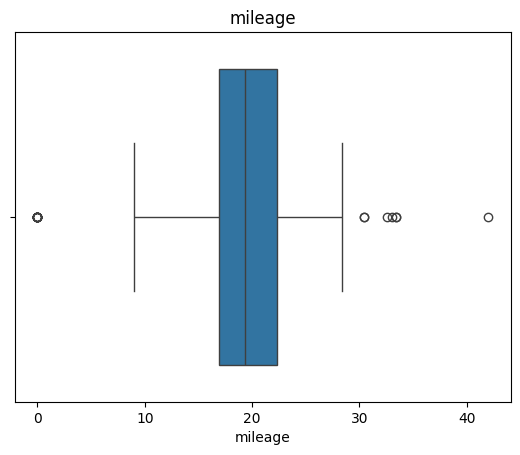

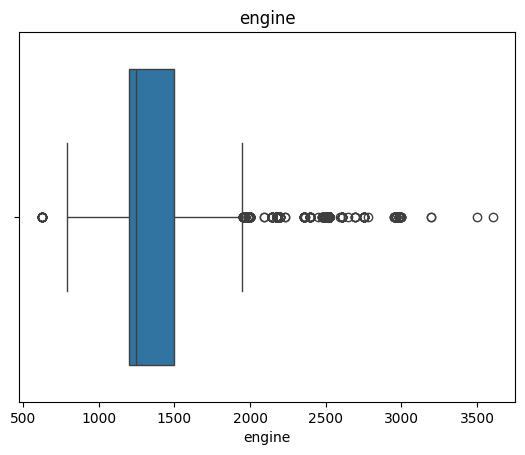

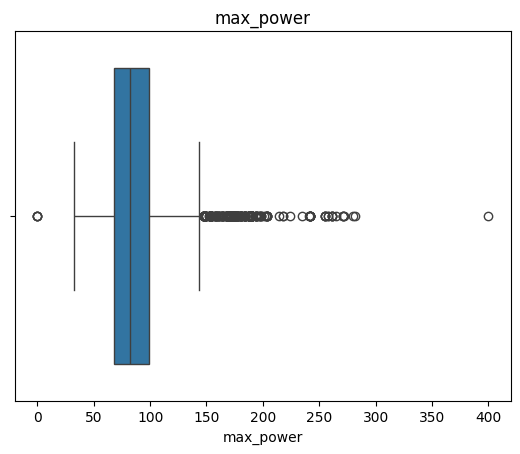

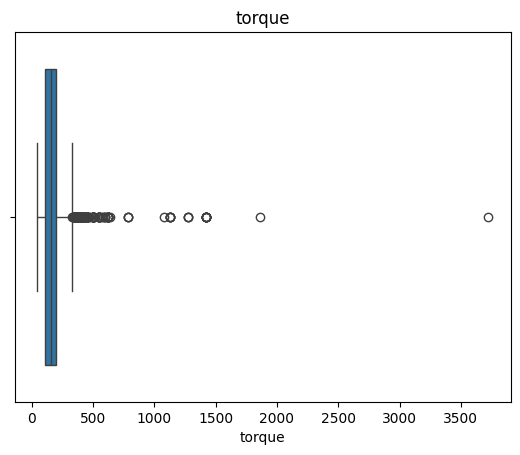

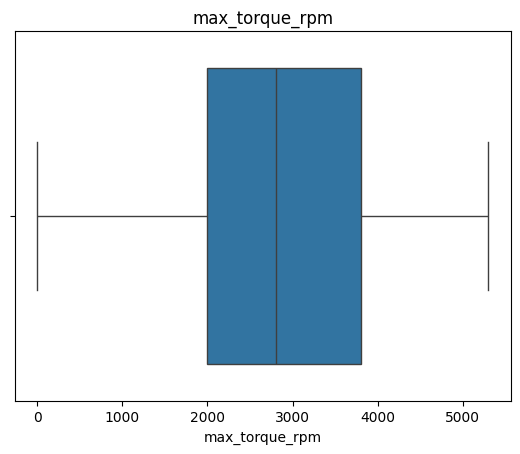

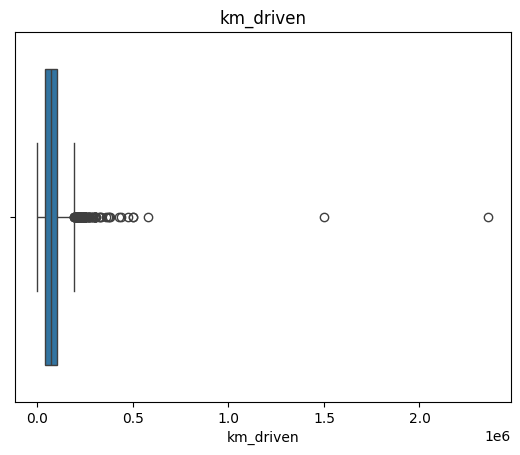

Общее число признаков: 49
  0. mileage
  1. engine
  2. max_power
  3. torque
  4. max_torque_rpm
  5. km_driven
  6. max_power_log
  7. engine_log
  8. torque_log
  9. power_per_liter
 10. km_driven_log
 11. is_high_mileage
 12. age
 13. age_sq
 14. cat__fuel_CNG
 15. cat__fuel_Diesel
 16. cat__fuel_LPG
 17. cat__fuel_Petrol
 18. cat__seller_type_Dealer
 19. cat__seller_type_Individual
 20. cat__seller_type_Trustmark Dealer
 21. cat__transmission_Automatic
 22. cat__transmission_Manual
 23. cat__owner_First Owner
 24. cat__owner_Fourth & Above Owner
 25. cat__owner_Second Owner
 26. cat__owner_Test Drive Car
 27. cat__owner_Third Owner
 28. cat__name_0
 29. cat__name_1
 30. cat__name_2
 31. cat__name_3
 32. cat__name_4
 33. cat__seats_2
 34. cat__seats_4
 35. cat__seats_5
 36. cat__seats_6
 37. cat__seats_7
 38. cat__seats_8
 39. cat__seats_9
 40. cat__seats_10
 41. cat__seats_14
 42. cat__car_class_hatchback
 43. cat__car_class_luxury
 44. cat__car_class_mpv
 45. cat__car_class_other

In [40]:
from scipy.sparse import hstack

#для начала посмотрим на выбросы
for col in numeric_cols:
    sns.boxplot(x=df_num_train[col])
    plt.title(col)
    plt.show()

#сменим вид наших признаков
df_num_train_bonus = df_num_train.copy()
df_num_test_bonus = df_num_test.copy()

df_num_train_bonus["max_power_log"] = np.log1p(df_num_train_bonus["max_power"])
df_num_test_bonus["max_power_log"] = np.log1p(df_num_test_bonus["max_power"])

df_num_train_bonus["engine_log"] = np.log1p(df_num_train_bonus["engine"])
df_num_test_bonus["engine_log"] = np.log1p(df_num_test_bonus["engine"])

df_num_train_bonus["torque_log"] = np.log1p(df_num_train_bonus["torque"])
df_num_test_bonus["torque_log"] = np.log1p(df_num_test_bonus["torque"])

#докинем мощность
df_num_train_bonus["power_per_liter"] = df_num_train_bonus["max_power"] / df_num_train_bonus["engine"]
df_num_test_bonus["power_per_liter"] = df_num_test_bonus["max_power"] / df_num_test_bonus["engine"]

#чуть срежем потенциальные выбросы (тут они весьма вероятно именно выбросы)
low, high = df_num_train_bonus["torque"].quantile([0.01, 0.99])
df_num_train_bonus["torque"] = df_num_train_bonus["torque"].clip(low, high)
df_num_test_bonus["torque"] = df_num_test_bonus["torque"].clip(low, high)

#вот это вот стремные оч значения, либо там совсем тачки убитые
df_num_train_bonus.loc[df_num_train_bonus["mileage"] < 2, "mileage"] = df_num_train_bonus["mileage"].median()
df_num_test_bonus.loc[df_num_test_bonus["mileage"] < 2, "mileage"] = df_num_train_bonus["mileage"].median()

#основываясь на бонусных графиках для зависимостей накидаем признаков
df_num_train_bonus["km_driven_log"] = np.log1p(df_num_train_bonus["km_driven"])
df_num_test_bonus["km_driven_log"] = np.log1p(df_num_test_bonus["km_driven"])
df_num_train_bonus["is_high_mileage"] = (df_num_train_bonus["km_driven"] > 150000).astype(int)
df_num_test_bonus["is_high_mileage"] = (df_num_test_bonus["km_driven"] > 150000).astype(int)

#возраст тачки вместо года (я конечно не оч шарю в рынке бу авто, но интуитивно кажется что проще работать через возраст)
df_num_train_bonus["age"] = 2024 - df_train["year"].values
df_num_test_bonus["age"] = 2024 - df_test["year"].values
df_num_train_bonus["age_sq"] = df_num_train_bonus["age"] ** 2
df_num_test_bonus["age_sq"] = df_num_test_bonus["age"] ** 2

#df["name"].unique()
#онлайн ллм-ку цеплять не буду для определения этого признака
def car_class_from_name(name):
    name = name.lower()

    # топ класс
    if any(b in name for b in ["bmw", "mercedes", "audi", "jaguar", "volvo", "lexus"]):
        return "luxury"

    # кроссовер
    suv_keys = [
        "scorpio","xuv","brezza","creta","ecosport","duster","fortuner",
        "venue","safari","s-cross","kodiaq","captiva","rexton","pajero",
        "compass","wr-v","city cross"
    ]
    if any(k in name for k in suv_keys):
        return "suv"

    # минивен
    mpv_keys = ["innova", "ertiga", "triber", "marazzo", "xylo", "enjoy", "mobilio", "stile"]
    if any(k in name for k in mpv_keys):
        return "mpv"

    # седан
    sedan_keys = [
        "city", "civic", "verna", "ciaz", "sx4", "swift dzire", "dzire",
        "accent", "rapid", "octavia", "vento", "corolla", "altis",
        "linea","fiesta","sunny","scala","elantra","sonata","sail sedan"
    ]
    if any(k in name for k in sedan_keys):
        return "sedan"

    # хэтчбек
    hatch_keys = [
        "alto","wagon r","i10","i20","santro","baleno","polo","tiago",
        "kwid","ignis","zen","estilo","figo","micra","ritz","eon","go","swift"
    ]
    if any(k in name for k in hatch_keys):
        return "hatchback"

    # пикап
    pickup_keys = ["bolero", "tuv","camper","supro"]
    if any(k in name for k in pickup_keys):
        return "pickup"

    #и особенные
    return "other"

# а теперь увлекательный сбор по всем признакам что были преобразованы и до того ;)
df_train["car_class"] = df_train["name"].apply(car_class_from_name)
df_test["car_class"] = df_test["name"].apply(car_class_from_name)

df_cat_train["car_class"] = df_train["car_class"]
df_cat_test["car_class"] = df_test["car_class"]

X_train_for_bonus = df_num_train_bonus.drop(columns=["selling_price"])
y_train_for_bonus = df_num_train_bonus["selling_price"]
X_test_for_bonus = df_num_test_bonus.drop(columns=["selling_price"])
y_test_for_bonus = df_num_test_bonus["selling_price"]

scaler_bonus = StandardScaler()
X_train_num_scaled = scaler_bonus.fit_transform(X_train_for_bonus)
X_test_num_scaled = scaler_bonus.transform(X_test_for_bonus)

X_train_cat = df_cat_train.drop(columns=["selling_price"])
X_test_cat = df_cat_test.drop(columns=["selling_price"])

cat_cols = ["fuel", "seller_type", "transmission", "owner", "name", "seats", "car_class"]

ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

X_train_cat_enc = ct.fit_transform(X_train_cat)
X_test_cat_enc = ct.transform(X_test_cat)

X_train_bonus = hstack([X_train_num_scaled, X_train_cat_enc])
X_test_bonus = hstack([X_test_num_scaled, X_test_cat_enc])

y_train_bonus = y_train_for_bonus
y_test_bonus = y_test_for_bonus
# 1. Имена числовых признаков
num_feature_names = X_train_for_bonus.columns.tolist()

# 2. Имена категориальных признаков из ColumnTransformer
try:
    # новый sklearn (1.0+)
    cat_feature_names = ct.get_feature_names_out()
except TypeError:
    # старый sklearn — нужно передать имена входных фичей,
    # и именно те, на которых CT был обучен: X_train_cat.columns
    cat_feature_names = ct.get_feature_names_out(input_features=X_train_cat.columns)

# 3. Итоговый список фичей в том же порядке, что и в X_train_bonus = hstack([...])
all_feature_names = num_feature_names + list(cat_feature_names)

print("Общее число признаков:", len(all_feature_names))
for i, name in enumerate(all_feature_names):
    print(f"{i:3d}. {name}")

In [41]:
#теперь обучим
param_grid_ridge = {
    "alpha": np.logspace(-4, 4, 20)
}

ridge = Ridge()

grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    cv=10,
    scoring="r2",
    n_jobs=-1
)

grid_ridge.fit(X_train_bonus, y_train_bonus)
best_ridge = grid_ridge.best_estimator_

y_pred_train_ridge_mod = best_ridge.predict(X_train_bonus)
y_pred_test_ridge_mod  = best_ridge.predict(X_test_bonus)

calc_stats(y_train_bonus, y_pred_train_ridge_mod, y_test_bonus, y_pred_test_ridge_mod)
print("Лучшие гиперпараметры:", grid_ridge.best_params_)

R^2 трейн: 0.7716030874806212
R^2 тест : 0.7833533689751453

MSE трейн: 65467311490.626305
MSE тест : 124534669995.95224
Лучшие гиперпараметры: {'alpha': np.float64(4.281332398719396)}


Нууууууу как-то мало прироста, он конечно есть, но не такой как я хотел

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [42]:
def business_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    rel_err = np.abs(y_true - y_pred) / y_true

    return np.mean(rel_err <= 0.10)

model_names = [
    "first_linear",
    "upd_linear",
    "lasso",
    "best_lasso",
    "elastic_net",
    "ridge",
    "iht_best",
    "ridge_modified",
]

model_preds = [
    y_pred_test_first_linear,
    y_pred_test_upd_linear,
    y_pred_test_lasso,
    y_pred_best_lasso_test,
    y_pred_test_en,
    y_pred_test_ridge,
    y_pred_test_iht_best,
    y_pred_test_ridge_mod
]

rows = []
for name, pred in zip(model_names, model_preds):
    score = business_metrics(y_test, pred)
    rows.append([name, score])


df_business = pd.DataFrame(rows, columns=["Модель", "Метрика"])
display(df_business)

,Модель,Метрика
0,first_linear,0.183
1,upd_linear,0.183
2,lasso,0.183
3,best_lasso,0.181
4,elastic_net,0.183
5,ridge,0.285
6,iht_best,0.157
7,ridge_modified,0.264


Здесь лучше всего справляется обычная ридж модель - она дает более точный прогноз на 10 процентах.

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [43]:
#если метрика должна быть понятна бизнесу, значит вывод либо в единицах прогноза либо в процентах
#за основу возьму МАПЕ с процентным выводом
#в случае недопрогноза будем множиться на коэффициент
#еще добавим логику увеличения ошибки в случае большего удаления недопрогноза
#1.0 - идеальный результат
def your_business_metrics(y_true, y_pred, beta=1.0):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    rel_err = np.abs(y_pred - y_true) / y_true
    under = y_pred < y_true

    weighted_err = rel_err.copy()

    weighted_err[under] = rel_err[under] + beta * (rel_err[under] ** 2)

    score = 1.0 - weighted_err.mean()
    return max(0.0, score)

rows = []
for name, pred in zip(model_names, model_preds):
    score = your_business_metrics(y_test, pred)
    rows.append([name, score])


df_my_business = pd.DataFrame(rows, columns=["Модель", "Метрика"])
display(df_my_business)

,Модель,Метрика
0,first_linear,0.000000
1,upd_linear,0.000000
2,lasso,0.000000
3,best_lasso,0.000000
4,elastic_net,0.000000
5,ridge,0.043485
6,iht_best,0.291475
7,ridge_modified,0.463910


Эту метрику уже не так просто будет объяснить гендиру, как предыдущую. По сути она показывает на сколько точно модель может предсказать цену желаему для бизнеса и при этом не спугнуть клиента. (Штраф за недопрогноз тем больше чем больше удаление в меньшую сторону, штраф за перепрогноз не пропал)
Судя по данной метрики лучше всего справляется ридж модель с модифицированными признаками, причем заметно.

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 25**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

______________
Я так понял что часть с md и pickle это для второй части дз. (тут все модели быстро обучаются, а все выводы сделаны после ячеек где их просят)

# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

In [44]:
import joblib

joblib.dump(best_ridge, "final_ridge_model.pkl")

['final_ridge_model.pkl']

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.

**И ссылку на приложение в StreamlitHub.**


### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.
